# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [127]:
import numpy as np
import icecream as ic

In [128]:
"""************* 所有图节点的父类 *************"""
class Node:

    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        # 每个节点都是其输入节点的输出节点
        for n in self.inputs:
            n.outputs.append(self)
    
        self.value = None
        
        self.gradients = {}
        # key为节点，value为梯度
        
    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    
    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented
        
"""************* 输入 *************"""
class Input(Node):
    
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        #前向传播函数 

        if value is not None:
            self.value = value
            print(self.value)
            
    def backward(self):
        #反向传播函数
        
        self.gradients = {self:0} # 初始化梯度为0
        
        for n in self.outputs:
            #计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost*1
        
"""************* 添加 *************"""
class Add(Node):
    # 似乎没有用到这个类
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
        
    def forward(self):
        self.value = sum(map(lambda n:n.value, self.inputs))
        
"""************* 全连接网络层 *************"""
class Linear(Node):

    
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        #前向传播计算 y= w*x + b
        
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            
            grad_cost = n.gradients[self]
            
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost,self.inputs[1].value.T,)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T,grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost,axis=0,keepdims=False)
            
    
"""************* Sigmoid函数 *************"""   

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self,[node])
        
    def _sigmoid(self, x):
        return 1./(1+np.exp(-1 * x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.inputs[0]] = grad_cost * self.partial
        
"""************* MSE均方差 *************"""  
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        
        self.value = np.mean(self.diff**2)
        
        
    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        
        
"""************* 执行所有节点的前向传播和反向传播 *************"""        

def forward_and_backward(outputnode, graph):

    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()
        
"""************* 拓扑排序 *************"""      
        
def topological_sort(feed_dict):
    
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L
        
"""************* SGD随机梯度下降 *************""" 

def sgd_update(trainables, learn_rate = 1e-2):
    for t in trainables:
        t.value += -1 * learn_rate * t.gradients[t]

In [129]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalization
X_ = (X_ - np.mean(X_,axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural Network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y,l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [4]:
losses = []
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, Loss: 121.393
Epoch: 101, Loss: 8.617
Epoch: 201, Loss: 6.925
Epoch: 301, Loss: 5.846
Epoch: 401, Loss: 4.468
Epoch: 501, Loss: 4.295
Epoch: 601, Loss: 4.240
Epoch: 701, Loss: 4.687
Epoch: 801, Loss: 4.157
Epoch: 901, Loss: 3.796
Epoch: 1001, Loss: 4.557
Epoch: 1101, Loss: 5.015
Epoch: 1201, Loss: 4.253
Epoch: 1301, Loss: 3.717
Epoch: 1401, Loss: 3.752
Epoch: 1501, Loss: 3.292
Epoch: 1601, Loss: 3.493
Epoch: 1701, Loss: 4.507
Epoch: 1801, Loss: 3.823
Epoch: 1901, Loss: 3.504
Epoch: 2001, Loss: 3.407
Epoch: 2101, Loss: 2.825
Epoch: 2201, Loss: 3.888
Epoch: 2301, Loss: 3.715
Epoch: 2401, Loss: 3.659
Epoch: 2501, Loss: 3.538
Epoch: 2601, Loss: 3.207
Epoch: 2701, Loss: 3.084
Epoch: 2801, Loss: 3.050
Epoch: 2901, Loss: 3.551
Epoch: 3001, Loss: 3.686
Epoch: 3101, Loss: 3.347
Epoch: 3201, Loss: 3.541
Epoch: 3301, Loss: 3.564
Epoch: 3401, Loss: 3.254
Epoch: 3501, Loss: 3.421
Epoch: 3601, Loss: 3.131
Epoch: 3701, Loss: 3.985
Epoch: 3801, Loss: 3.337
Epoch: 3901, Loss: 3.089
Epoch: 400

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

Ans:
$$ z = w^Tx + b$$
代表权重*输入特征+ 偏差
$$ a = \sigma (z)$$
激活函数a可以是sigmoid函数、tanh函数、Relu函数、Leaky Relu函数等

####  2. Why we use non-linear activation funcitons in neural networks?

Ans:

因为如果使用线性激活函数，多个隐藏层其实就可以用一个隐藏层代替，多个隐藏层就变得没有意义，深度也就没有意义了

#### 3. What is the 'Logistic Loss' ?

$$ Loss = -ylog\hat y - (1-y)log(1 - \hat y) $$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

Ans: C

sigmoid 常用于二分类问题

tanh 效果非常好，几乎适用于所有场合

ReLu 最常用的默认函数，学习速度快

Leaky ReLu 优化版的ReLu



#### 5. Why we don't use zero initialization for all parameters ?

如果所有参数初始化为0，会使神经网络产生对称破坏问题，也就是每一层向前传播的激活函数计算的结果是一样的，每一层反向传播计算的梯度也是一样的，所有的隐藏层都是对称的。无论迭代多少次，loss都不会得到改善。解决这个问题的方法就是随机初始化参数。

#### 6. Can you implement the softmax function using python ? 

Ans:
$$softmax = \frac{e^{z_j}}{\sum _j^n e^{z_j}}$$

In [14]:
def softmax_func(Z):
    return np.exp(Z) / np.sum(np.exp(Z))

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [99]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
%matplotlib inline

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [172]:
# Loading the data 
digits = datasets.load_digits()

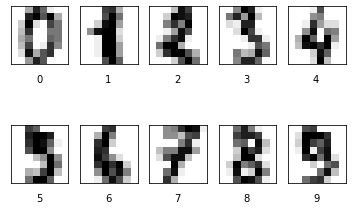

In [173]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [174]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
X_train = X_train/255
X_test = X_test/255

In [175]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [176]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

In [177]:
# !pwd

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [178]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
#     assert(len(z)!=0)
    s = 1. / (1 + np.exp(-1 * z))
    
    return s

In [179]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [180]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim,1)
    b = np.random.randint(1)
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [181]:
n_features = X_train.shape[1]
W_, b_ = initialize_parameters(n_features)

In [182]:
print('W_ param：\n{}'.format(W_[:10]))
print('--'*10)
print('b_ param：{}'.format(b_))

W_ param：
[[ 0.60972133]
 [ 1.59981409]
 [ 0.77354545]
 [-0.33123535]
 [-0.57528225]
 [-0.7654119 ]
 [ 0.69177604]
 [-0.25069194]
 [ 0.13311196]
 [ 1.34554745]]
--------------------
b_ param：0


#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)})+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [187]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    z = np.dot(X,w) + b
    A = sigmoid(z)
    Y_r = Y.reshape(-1,1) 
    
    cost = -1 * np.sum(Y_r * np.log(A)+(1 - Y_r) * np.log(1-A)) / X.shape[0]

    dw = np.dot(X.T,(A-Y_r)) / m
    db = np.sum(A-Y_r) / m
    assert(dw.shape == w.shape)
    
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [188]:
# propagate(W_,b_,X_train,y_train)

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [189]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    best_w = copy.deepcopy(w)
    best_b = copy.deepcopy(b)
    for i in range(num_iterations):
        
        grads, cost = propagate(best_w,best_b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        best_w += -1 * learning_rate * dw
        best_b += -1 * learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":best_w,
              "b":best_b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params,grads,costs

In [191]:
last_params,last_grads,last_costs = optimize(W_,b_,X_train,y_train,30000,0.3,print_cost=True)

Cost after iteration 0: 0.700397
Cost after iteration 100: 0.633249
Cost after iteration 200: 0.583000
Cost after iteration 300: 0.544427
Cost after iteration 400: 0.514051
Cost after iteration 500: 0.489570
Cost after iteration 600: 0.469434
Cost after iteration 700: 0.452580
Cost after iteration 800: 0.438259
Cost after iteration 900: 0.425931
Cost after iteration 1000: 0.415196
Cost after iteration 1100: 0.405756
Cost after iteration 1200: 0.397381
Cost after iteration 1300: 0.389893
Cost after iteration 1400: 0.383151
Cost after iteration 1500: 0.377044
Cost after iteration 1600: 0.371481
Cost after iteration 1700: 0.366387
Cost after iteration 1800: 0.361701
Cost after iteration 1900: 0.357373
Cost after iteration 2000: 0.353360
Cost after iteration 2100: 0.349626
Cost after iteration 2200: 0.346141
Cost after iteration 2300: 0.342877
Cost after iteration 2400: 0.339814
Cost after iteration 2500: 0.336931
Cost after iteration 2600: 0.334212
Cost after iteration 2700: 0.331640
Cost

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [192]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
#     w = w.reshape(m,1)

    z = np.dot(X,w) + b
    A = sigmoid(z)

    Y_prediction = copy.deepcopy(A)
    Y_prediction[Y_prediction>0.5] =1
    Y_prediction[Y_prediction<=0.5] = 0
    Y_prediction = Y_prediction.squeeze()
    assert(Y_prediction.shape[0] == X.shape[0])
    
    return Y_prediction

def classify_accuracy(truth,pred):
    accuracy = truth[pred==truth].shape[0]/truth.shape[0]
    
    return accuracy



In [193]:
X_test.shape

(450, 64)

In [194]:
y_test_pred = predict(last_params['w'],last_params['b'],X_test)

In [195]:
classify_accuracy(y_test,y_test_pred)

0.8688888888888889

In [196]:
y_train_pred = predict(last_params['w'],last_params['b'],X_train)

In [197]:
classify_accuracy(y_train,y_train_pred)

0.9168522642910171

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [198]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    # step 1 initialize params W,b 
    dim = X_train.shape[1]
    W_, b_ = initialize_parameters(dim)
    
    # step 2 propagate & optimize like forward propagation & backward propagation
    last_params,last_grads,last_costs = optimize(W_,b_,X_train,Y_train,num_iterations,learning_rate,print_cost)
    w = last_params['w']
    b = last_params['b']
    
    # step 3 predict
    Y_train_pred = predict(w, b, X_train)
    Y_test_pred = predict(w, b, X_test)
    
    # step 4 compute accuracy
    training_accuracy = classify_accuracy(Y_train,Y_train_pred)
    test_accuracy = classify_accuracy(Y_test,Y_test_pred)
    
    # step 5 output
    result = {"w":w,
             "b":b,
             "training_accuracy": training_accuracy,
             "test_accuracy":test_accuracy,
             "cost":last_costs
    }
    
    return result
    
    
    

In [214]:
get_pred = model(X_train, y_train, X_test, y_test, 30000, 0.3,True)

Cost after iteration 0: 0.691207
Cost after iteration 100: 0.625882
Cost after iteration 200: 0.577466
Cost after iteration 300: 0.540209
Cost after iteration 400: 0.510790
Cost after iteration 500: 0.487017
Cost after iteration 600: 0.467418
Cost after iteration 700: 0.450978
Cost after iteration 800: 0.436983
Cost after iteration 900: 0.424913
Cost after iteration 1000: 0.414386
Cost after iteration 1100: 0.405115
Cost after iteration 1200: 0.396878
Cost after iteration 1300: 0.389503
Cost after iteration 1400: 0.382854
Cost after iteration 1500: 0.376824
Cost after iteration 1600: 0.371324
Cost after iteration 1700: 0.366282
Cost after iteration 1800: 0.361639
Cost after iteration 1900: 0.357346
Cost after iteration 2000: 0.353362
Cost after iteration 2100: 0.349652
Cost after iteration 2200: 0.346185
Cost after iteration 2300: 0.342937
Cost after iteration 2400: 0.339886
Cost after iteration 2500: 0.337012
Cost after iteration 2600: 0.334299
Cost after iteration 2700: 0.331732
Cost

In [200]:
get_pred.keys()

dict_keys(['w', 'b', 'training_accuracy', 'test_accuracy', 'cost'])

In [201]:
print("training_accuracy: {}".format(get_pred['training_accuracy']))
print("test_accuracy: {}".format(get_pred['test_accuracy']))

training_accuracy: 0.9168522642910171
test_accuracy: 0.8688888888888889


### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [202]:
dic_cost = {}
for lr_i in [0.3, 0.1, 0.05, 0.01, 0.005, 0.001]:
    get_pred = model(X_train, y_train, X_test, y_test, 50000, lr_i,False)
    dic_cost[str(lr_i)] = get_pred['cost']


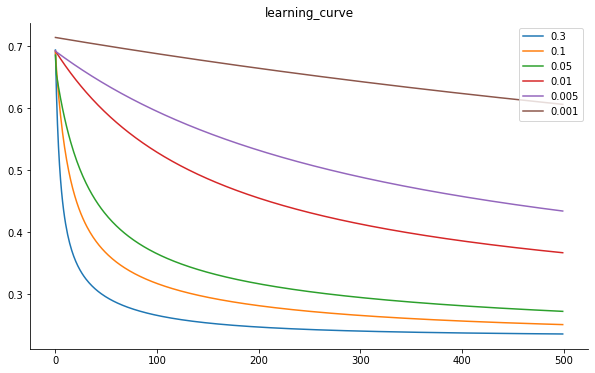

In [203]:
plt.figure(figsize=(10,6))
for cost_i in dic_cost:
    plt.plot(dic_cost[cost_i],label=cost_i)
    plt.legend(loc='upper right')
plt.title('learning_curve')
sns.despine()


总结：学习率过大会造成训练速度过快，以至于无法收敛，而学习率过小则造成训练速度慢，消耗过多时间和空间

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [216]:
dic_cost = {}
for in_i in [1000,5000,10000,30000,50000]:
    get_pred = model(X_train, y_train, X_test, y_test, in_i, 0.01,False)
    dic_cost[str(in_i)] = get_pred['cost']
    print('iteration_num :{} ,test_accuracy :{}\n'.format(str(in_i),get_pred['test_accuracy']))

iteration_num :1000 ,test_accuracy :0.6688888888888889

iteration_num :5000 ,test_accuracy :0.7822222222222223

iteration_num :10000 ,test_accuracy :0.8333333333333334

iteration_num :30000 ,test_accuracy :0.8644444444444445

iteration_num :50000 ,test_accuracy :0.8555555555555555



(-10, 120)

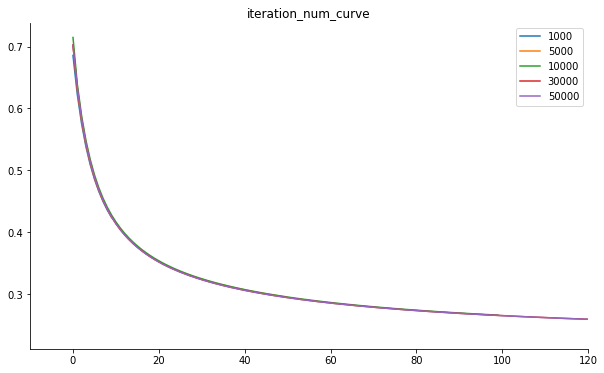

In [212]:
plt.figure(figsize=(10,6))
for cost_i in dic_cost:
    plt.plot(dic_cost[cost_i],label=cost_i)
    plt.legend(loc='upper right')
plt.title('iteration_num_curve')
sns.despine()
plt.xlim([-10,120])

总结：迭代次数过少会达不到最优解,迭代次数过大会造成资源浪费

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

In [206]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
%matplotlib inline

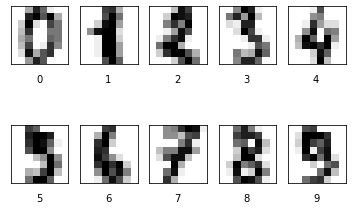

In [207]:
# Loading the data 
digits = datasets.load_digits()

# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
set(y_train)

(1347, 64)
(450, 64)
(1347,)
(450,)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## define softmax

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ a^{(i)} = sigmoid(z^{(i)}) = \frac{e^{z^{(i)}}}{\sum e^{z^{(j)}}} $$

 $$L(a^{(i)},y^{(i)}) = -y^{(i)} + log\sum_j e^{a^{(j)}}$$




In [12]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z))


def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim,1)
    b = np.random.randint(1)
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    z = np.dot(X,w) + b
    A = softmax(z)
    # 使用softmax作为激活函数
    
    Y_r = Y.reshape(-1,1) 
    
    cost = -Y_r + np.log1p(np.sum(np.exp(A))) 
    # 这里改为softmax的loss function
    dw = np.dot(X.T,(A-Y_r)) / m
    db = np.sum(A-Y_r) / m
    
    
    assert(dw.shape == w.shape)
    
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

# Congratulations ! You have completed assigment 4. 